Introduction:
    
Due to the surge in Covid-19 cases, there has been a huge increase in demand in inpatient services in hospitals. Hence, it has become important for hospitals to predict the length of stay for patients with different diagnoses to more accurately allocate them to the hospitals available. 

Using the data from different hospitals in different regions with various illnesses, we will train a model to help predict the length of stay of an incoming patient.

1. Import datasets and libraries

In [2]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import plotly.express as px
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
plotly.offline.init_notebook_mode (connected = True)

In [3]:
patients = pd.read_csv('train_data.csv')
patients.info()
# missing data: bed grade, city_code_patient

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
case_id                              318438 non-null int64
Hospital_code                        318438 non-null int64
Hospital_type_code                   318438 non-null object
City_Code_Hospital                   318438 non-null int64
Hospital_region_code                 318438 non-null object
Available Extra Rooms in Hospital    318438 non-null int64
Department                           318438 non-null object
Ward_Type                            318438 non-null object
Ward_Facility_Code                   318438 non-null object
Bed Grade                            318325 non-null float64
patientid                            318438 non-null int64
City_Code_Patient                    313906 non-null float64
Type of Admission                    318438 non-null object
Severity of Illness                  318438 non-null object
Visitors with Patient                318438 non-null

In [4]:
patients['Count']=1

In [5]:
patients.isna().any()

case_id                              False
Hospital_code                        False
Hospital_type_code                   False
City_Code_Hospital                   False
Hospital_region_code                 False
Available Extra Rooms in Hospital    False
Department                           False
Ward_Type                            False
Ward_Facility_Code                   False
Bed Grade                             True
patientid                            False
City_Code_Patient                     True
Type of Admission                    False
Severity of Illness                  False
Visitors with Patient                False
Age                                  False
Admission_Deposit                    False
Stay                                 False
Count                                False
dtype: bool

In [6]:
patients.head()
# identify categorical variables

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay,Count
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10,1
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50,1
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40,1
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50,1
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50,1


2. EDA & Visualisations

In [7]:
patients['Hospital_type_code'].value_counts()
# each hospital has a Hospital_type_code and Hospital_region_code

a    143425
b     68946
c     45928
e     24770
d     20389
f     10703
g      4277
Name: Hospital_type_code, dtype: int64

In [8]:
# add Hospital_type_code as a column instead of an index
hostypegrp = patients.groupby('Hospital_type_code')['Count'].sum().reset_index().sort_values(by='Count',ascending=False)
print(hostypegrp)

  Hospital_type_code   Count
0                  a  143425
1                  b   68946
2                  c   45928
4                  e   24770
3                  d   20389
5                  f   10703
6                  g    4277


In [9]:
fig1=px.bar(hostypegrp,x='Hospital_type_code',y='Count',color='Count',labels={'Hospital_type_code':'Hospital Type Code','Count':'Number of patients'})
fig1.show()

In [10]:
fig2=px.sunburst(patients,path=['Hospital_region_code','Hospital_type_code'])
fig2.show()
# Region Y and Z seem to be underutilising hospitals a,d and f,d,g respectively

In [11]:
# check for extra tooms in each hospital
patient_beds = patients[['Hospital_code', 'Available Extra Rooms in Hospital', 'Hospital_region_code']]
# substitute area codes for numbers
patient_beds['Hospital_region_code'] = patient_beds['Hospital_region_code'].map({'X': 1, 'Y': 2, 'Z': 3})
bedgrp = patient_beds.groupby('Hospital_code')[['Available Extra Rooms in Hospital', 'Hospital_region_code']].median().reset_index()

C:\Users\shiqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [12]:
bedgrp['Hospital_region_code'] = bedgrp['Hospital_region_code'].map({1:'X', 2:'Y', 3:'Z'})
bedgrp.head()

,Hospital_code,Available Extra Rooms in Hospital,Hospital_region_code
0,1,3,Y
1,2,2,Z
2,3,3,Z
3,4,3,X
4,5,3,X


In [13]:
patient_beds1 = bedgrp.groupby('Hospital_region_code')['Available Extra Rooms in Hospital'].sum().reset_index()
fig3 = px.pie(patient_beds1, values='Available Extra Rooms in Hospital', names='Hospital_region_code')
fig3.update_layout(title='Number of extra rooms in each region')
fig3.update_traces(textinfo='percent+label')

# almost equal distribution of extra rooms in each region (ideal)

In [14]:
# Check which departments have the highest number of case loads
deptgrp = patients.groupby('Department')['Count'].sum().reset_index().sort_values(by='Count', ascending=False)

In [15]:
fig4=px.bar(deptgrp, x='Department', y='Count', color='Department', labels={'Count': 'Number of patients'})
fig4.update_layout(title='Case load distribution per department')
fig4.show()

In [16]:
# Check case load per severity
sevgrp = patients.groupby('Severity of Illness')['Count'].sum().reset_index().sort_values(by='Count', ascending=False)

In [17]:
fig5=px.funnel(sevgrp, x='Count', y='Severity of Illness', color='Count', labels={'Count': 'Number of patients'})
fig5.update_layout(title='Case load distribution depending on Severity')
fig5.show()

In [18]:
# Check for relationship between age and severity of illness
fig6=px.sunburst(patients,path=['Age','Severity of Illness'])
fig6.update_layout(title='Age (in years) and Severity of Illness')
fig6.show()

# More extreme cases in older age groups

In [19]:
# Check relationship between severity and stay

fig7=px.sunburst(patients,path=['Stay','Severity of Illness'])
fig7.update_layout(title='Stay period (in days) vs Severity of illness')
fig7.show()

# As stay duration increases, no of extreme cases increases

3. Data cleaning

In [20]:
# Check for categorical data
patients.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay,Count
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10,1
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50,1
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40,1
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50,1
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50,1


In [21]:
from sklearn.preprocessing import LabelEncoder

In [22]:
le = LabelEncoder()

# transform hospital type code
patients['Hospital_type_code_cat'] = le.fit_transform(patients['Hospital_type_code'])

In [23]:
patients['Ward_Type_cat'] = le.fit_transform(patients['Ward_Type'])
patients['Ward_Facility_Code_cat'] = le.fit_transform(patients['Ward_Facility_Code'])
patients['Age_cat'] = le.fit_transform(patients['Age'])
patients['Stay_cat'] = le.fit_transform(patients['Stay'])

In [24]:
patient_reg_codes=pd.get_dummies(patients['Hospital_region_code'])
patients=pd.merge(patients,patient_reg_codes, on=patients.index)

In [25]:
patients.head()

,key_0,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,...,Stay,Count,Hospital_type_code_cat,Ward_Type_cat,Ward_Facility_Code_cat,Age_cat,Stay_cat,X,Y,Z
0,0,1,8,c,3,Z,3,radiotherapy,R,F,...,0-10,1,2,2,5,5,0,0,0,1
1,1,2,2,c,5,Z,2,radiotherapy,S,F,...,41-50,1,2,3,5,5,4,0,0,1
2,2,3,10,e,1,X,2,anesthesia,S,E,...,31-40,1,4,3,4,5,3,1,0,0
3,3,4,26,b,2,Y,2,radiotherapy,R,D,...,41-50,1,1,2,3,5,4,0,1,0
4,4,5,26,b,2,Y,2,radiotherapy,S,D,...,41-50,1,1,3,3,5,4,0,1,0


In [26]:
patients.drop('key_0', axis=1, inplace=True)

In [27]:
patient_dept=pd.get_dummies(patients['Department'])
patients=pd.merge(patients,patient_dept, on=patients.index)
patients.drop('key_0', axis=1, inplace=True)

patient_adm=pd.get_dummies(patients['Type of Admission'])
patients=pd.merge(patients,patient_adm, on=patients.index)
patients.drop('key_0', axis=1, inplace=True)

patient_sev=pd.get_dummies(patients['Severity of Illness'])
patients=pd.merge(patients,patient_sev, on=patients.index)
patients.drop('key_0', axis=1, inplace=True)

In [28]:
patients.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,...,anesthesia,gynecology,radiotherapy,surgery,Emergency,Trauma,Urgent,Extreme,Minor,Moderate
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,...,0,0,1,0,1,0,0,1,0,0
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,...,0,0,1,0,0,1,0,1,0,0
2,3,10,e,1,X,2,anesthesia,S,E,2.0,...,1,0,0,0,0,1,0,1,0,0
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,...,0,0,1,0,0,1,0,1,0,0
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,...,0,0,1,0,0,1,0,1,0,0


In [29]:
patients_train = patients.copy()

In [30]:
# drop unnecessary columns
cat_cols=['case_id', 'Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type', 'Ward_Facility_Code', 'Type of Admission', 'Severity of Illness', 'Age', 'Stay', 'Count', 'Bed Grade', 'City_Code_Patient']

for col in cat_cols:
    patients_train.drop(col, axis=1, inplace=True)

In [31]:
patients_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318438 entries, 0 to 318437
Data columns (total 25 columns):
Hospital_code                        318438 non-null int64
City_Code_Hospital                   318438 non-null int64
Available Extra Rooms in Hospital    318438 non-null int64
patientid                            318438 non-null int64
Visitors with Patient                318438 non-null int64
Admission_Deposit                    318438 non-null float64
Hospital_type_code_cat               318438 non-null int32
Ward_Type_cat                        318438 non-null int32
Ward_Facility_Code_cat               318438 non-null int32
Age_cat                              318438 non-null int32
Stay_cat                             318438 non-null int32
X                                    318438 non-null uint8
Y                                    318438 non-null uint8
Z                                    318438 non-null uint8
TB & Chest disease                   318438 non-null uint8
an

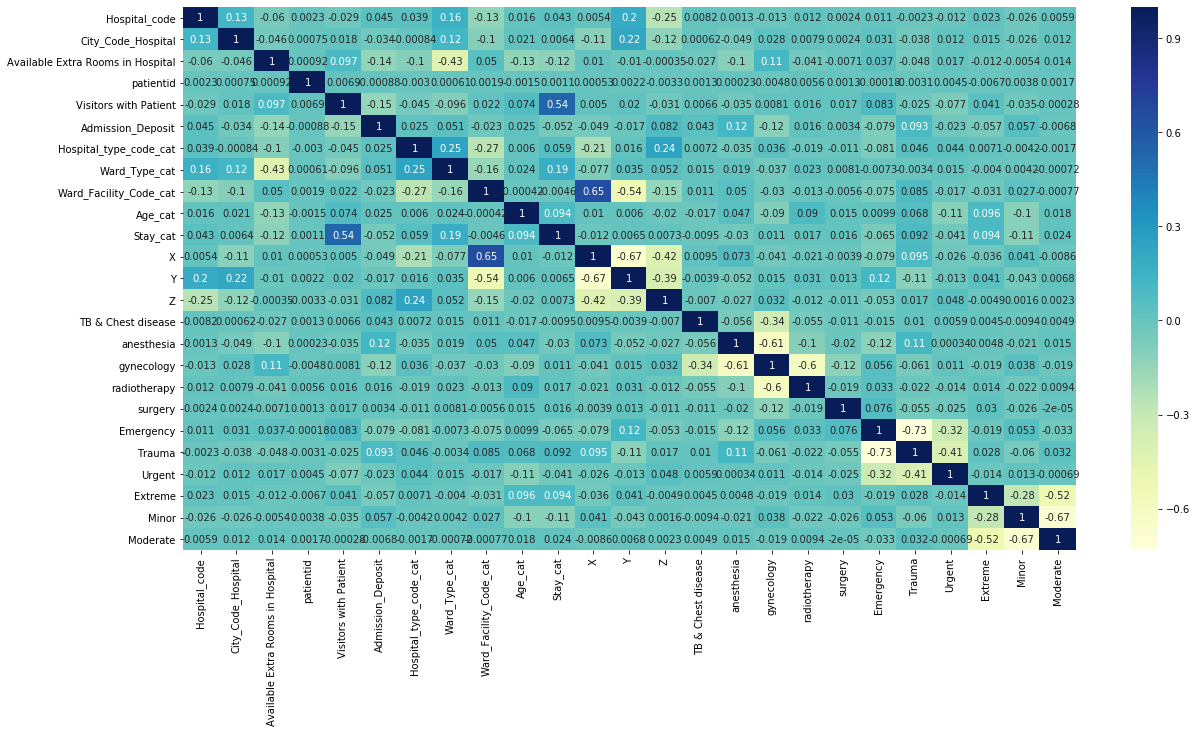

In [32]:
corr=patients_train.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr, annot=True, cmap='YlGnBu', fmt='.2g')

4. Machine Learning

a) Training: Logistic Regression

In [36]:
target=patients_train['Stay_cat']
train_patients=patients_train.iloc[:,:-1]

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
reg_log=LogisticRegression()

In [38]:
X_train,X_test,y_train,y_test=train_test_split(train_patients,target,test_size=0.3,shuffle=True,random_state=100)

In [39]:
reg_log.fit(X_train,y_train)

C:\Users\shiqi\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [40]:
reg_log.score(X_train,y_train)

0.27472566911612967

In [41]:
y_predict_log=reg_log.predict(X_test)
reg_log.score(X_test,y_test)

0.27487124733073737

In [ ]:
# 27% accuracy

b) Training: Random Forest Classifier

In [42]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(max_depth=10,random_state=100)

In [43]:
rfc.fit(X_train,y_train)
rfc.score(X_train,y_train)

0.8799583681013521

In [53]:
y_preds_rfc=rfc.predict(X_test)
rfc.score(X_test,y_test)

# better results than logreg

0.8786165892057112

5. Conclusion

Random Forest Classifier performed better than the Logistic Regression model in predicting the stay period of incoming patients. Although the accuracy is not extremely high, this information would prove useful in estimating the capacity of a hospital to take in patients, especially during a surge of inpatients